# **Deep Learning Project**
Done by: <br>
- Ana Farinha | 20211514
- Ana Reis | 20211631
- Beatriz Barreto | 20211547
- Mariana Neto | 20211527


### <font color='#b185db'> Mount drive and import libraries</font>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Libraries
import os
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score


### <font color='#b185db'> Import dataset</font>

Import metadata file.

In [9]:
metadata_df = pd.read_csv("/content/drive/MyDrive/ProjectDL23_24/HAM10000_metadata.csv")
metadata_df = metadata_df.set_index('image_id')
metadata_df

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...
ISIC_0033084,HAM_0002867,akiec,histo,40.0,male,abdomen
ISIC_0033550,HAM_0002867,akiec,histo,40.0,male,abdomen
ISIC_0033536,HAM_0002867,akiec,histo,40.0,male,abdomen


#### <font color='#b185db'>Images</font>

In [10]:
train_images_DIR = "/content/drive/MyDrive/ProjectDL23_24/train"
test_images_DIR = "/content/drive/MyDrive/ProjectDL23_24/test"

Resize the images to avoid problems with the RAM capacity. This function was taken form class 15.

In [12]:
def resize_and_create_arrays(directory):
  ## Define the X to store the arrays of images
  X=[]
  ## Define Y to store the labels of the images
  y=[]
  for img in tqdm(os.listdir(directory)):
    path = os.path.join(directory, img)
    # Get label and append to list
    y.append(metadata_df.at[img[:-4], 'dx'])
    # Apply image transformations
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    # Resize because of RAM
    img = cv2.resize(img, (50, 50))
    # Append to list
    X.append(np.array(img))
  # Return X and y
  return X, y

In [13]:
# Resize images and create X and y arrays for train directory
X_train, y_train = resize_and_create_arrays(train_images_DIR)

100%|██████████| 7511/7511 [02:43<00:00, 45.97it/s]


In [14]:
# Resize images and create X and y arrays for test directory
X_test, y_test = resize_and_create_arrays(test_images_DIR)

100%|██████████| 2504/2504 [00:53<00:00, 46.77it/s]


The code below converts the images into a NumPy array. This is needed for them to be used in a neural network.

In [15]:
# Convert X and y to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [16]:
print("Resized images and created X and y arrays.")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Resized images and created X and y arrays.
X_train shape: (7511, 50, 50, 3)
y_train shape: (7511,)
X_test shape: (2504, 50, 50, 3)
y_test shape: (2504,)


#### <font color='#b185db'>Label Encoding</font>
In order to use the labels on a neural network, they need to be in numerical format.

In [17]:
# Convert the labels into a numerical format
labelEncoder = LabelEncoder()
y_train = labelEncoder.fit_transform(y_train)
y_test = labelEncoder.transform(y_test)

# Rescaling of pixels
X_train = X_train/255
X_test = X_test/255

### <font color='#b185db'>Modeling</font>


Since the dataset is unbalanced we decided to use a Stratified K-Fold. The code for it was taken from Class 11.
The model was based on notebooks from many classes, like class 3, 9 and 13.

In [19]:
# Define an early stopping to prevent overfitting
earl_stop= EarlyStopping(monitor="loss", patience=3)

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/20
188/188 [==============================] - 22s 105ms/step - loss: 1.1127 - accuracy: 0.6678
Epoch 2/20
188/188 [==============================] - 19s 99ms/step - loss: 0.9924 - accuracy: 0.6698
Epoch 3/20
188/188 [==============================] - 18s 98ms/step - loss: 0.9186 - accuracy: 0.6733
Epoch 4/20
188/188 [==============================] - 18s 96ms/step - loss: 0.9010 - accuracy: 0.6788
Epoch 5/20
188/188 [==============================] - 20s 105ms/step - loss: 0.8609 - accuracy: 0.6858
Epoch 6/20
188/188 [==============================] - 19s 104ms/step - loss: 0.8370 - accuracy: 0.6946
Epoch 7/20
188/188 [==============================] - 20s 106ms/step - loss: 0.8132 - accuracy: 0.6969
Epoch 8/20
188/188 [==============================] - 21s 110ms/step - loss: 0.7899 - accuracy: 0.7101
Epoch 9/20
188/188 [==============================] - 18s 97ms/step - loss: 0.7733

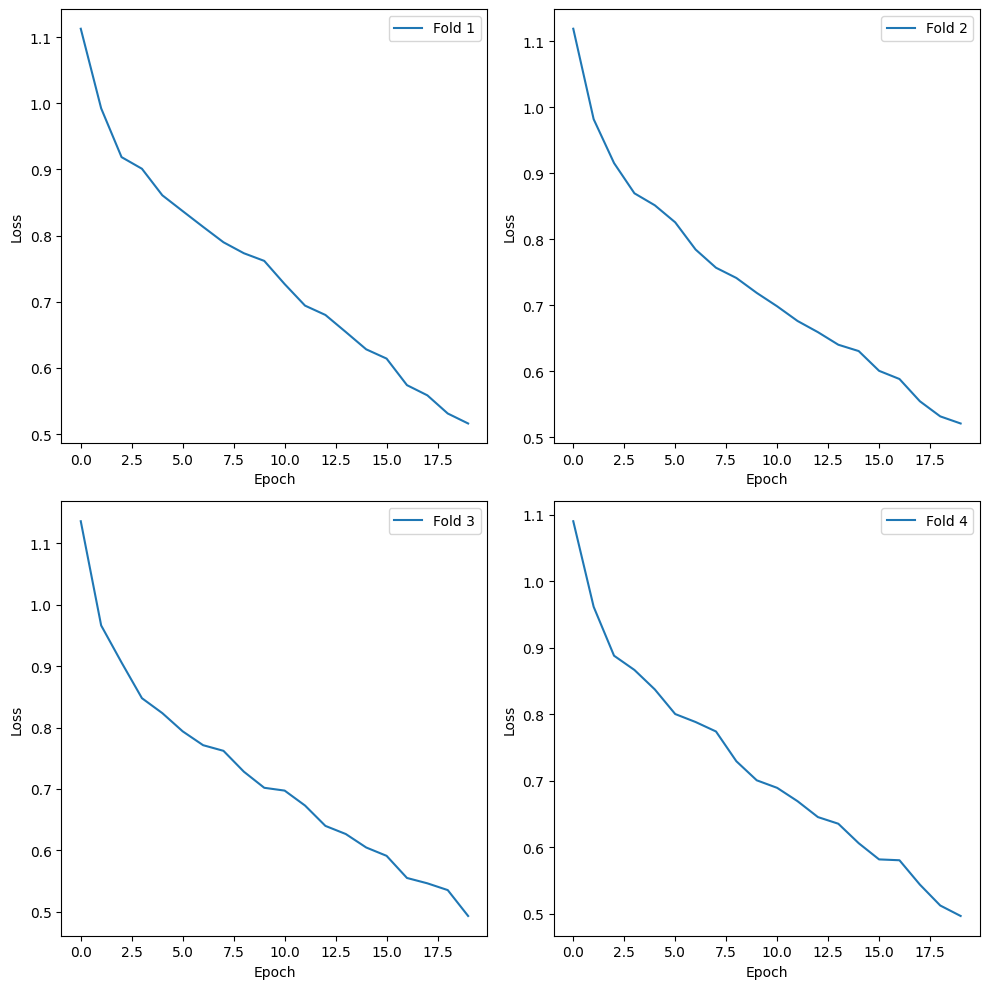

In [21]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []
history_per_fold = []
f1_per_fold = []

# Define the Cross Validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross Validation model evaluation
fold_no = 1
for train, test in skf.split(X_train, y_train):

    # Best model from grid search
    model = Sequential()
    model.add(Conv2D(20, kernel_size = (2, 2), padding='same', activation = 'relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(60, kernel_size = (2, 2), padding='same', activation = 'relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(80, kernel_size = (2, 2), padding='same', activation = 'relu'))
    model.add(MaxPooling2D((2,2)))
    model.add(Flatten())
    model.add(Dense(352, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(7, activation='softmax'))

    model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model and store the losses per fold during training
    history = model.fit(X_train[train], y_train[train],
                        batch_size=32,
                        epochs=20,
                        verbose=1,
                        callbacks=[earl_stop])
    history_per_fold.append(history.history['loss'])

    # Generate generalization metrics and evaluate on the k-1 fold
    y_pred = model.predict(X_train[test])
    y_pred_classes = np.argmax(y_pred, axis=1)

    f1 = f1_score(y_train[test], y_pred_classes, average='weighted')
    scores = model.evaluate(X_train[test], y_train[test], verbose=1)  # Fix: Use X_train and y_train for evaluation
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; F1 score: {f1}')
    f1_per_fold.append(f1)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no += 1

# Plot the loss for each fold in respect to the number of epochs it has trained
# Define the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

# Plot the loss for each fold
for fold, ax in enumerate(axes.flat):
    ax.plot(range(len(history_per_fold[fold])), history_per_fold[fold], label=f'Fold {fold+1}', color='#b185db')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()

# Tighten the layout
fig.tight_layout()

# Save the figure as a single image with four subplots
plt.savefig('training_loss_per_fold.png')
plt.show()

Let's see the scores of the loss, accuracy and weighted f1 for each folds and then, the average and standard deviation (where it applies) for all. This code was taken from the notebook from class 11.

In [56]:
#Provide average scores
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - F1 Score: {f1_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Mean Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print(f'> F1 Score: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
print('------------------------------------------------------------------------')


Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.7661645412445068 - F1 Score: 0.7251923821997792 - Accuracy: 74.98336434364319%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.7880836725234985 - F1 Score: 0.7164680143207671 - Accuracy: 74.50066804885864%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.7516619563102722 - F1 Score: 0.7422719099919236 - Accuracy: 75.83222389221191%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.7229936718940735 - F1 Score: 0.7532892027852502 - Accuracy: 76.764315366745%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.6797640323638916 - F1 Score: 0.7380468614324688 - Accuracy: 75.03328919410706%
------------------------------------------------------------------------
Average scores for all folds:
> Mean Accuracy: 75.422772169

### <font color='#b185db'>Modeling Evaluation</font>


In the code below we created a function to plot the confusion matrix.

In [30]:
def plot_confusion_matrix(y_true, y_pred):
    labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, labels, labels)
    ax = sns.heatmap(df_cm, annot=True, annot_kws={'size': 16}, square=True, cbar=False, fmt='g')
    ax.set_ylim(0, len(labels))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    ax.invert_yaxis()  # optional
    plt.show()

Evaluate on validation data

Here we used the preductions made on the stratified k-fold.

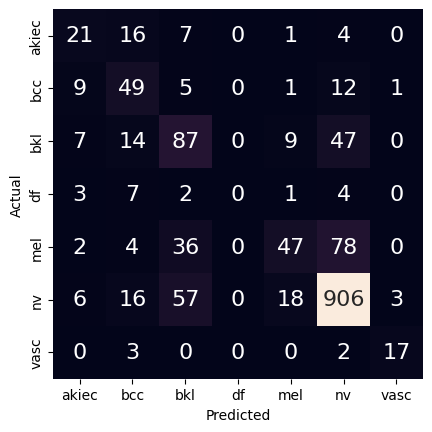

In [41]:
plot_confusion_matrix(y_train[test], y_pred_classes)

In [58]:
print('\nClassification Report - Validation\n')
print(classification_report(y_train[test], y_pred_classes))


Classification Report - Validation

              precision    recall  f1-score   support

           0       0.44      0.43      0.43        49
           1       0.45      0.64      0.53        77
           2       0.45      0.53      0.49       164
           3       0.00      0.00      0.00        17
           4       0.61      0.28      0.39       167
           5       0.86      0.90      0.88      1006
           6       0.81      0.77      0.79        22

    accuracy                           0.75      1502
   macro avg       0.52      0.51      0.50      1502
weighted avg       0.74      0.75      0.74      1502



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluate on test data

In [43]:
# Make predictions
y_pred = model.predict(X_test)
# Convert predictions and true labels back to original labels
y_pred = np.argmax(y_pred, axis=1)

79/79 [==============================] - 10s 127ms/step


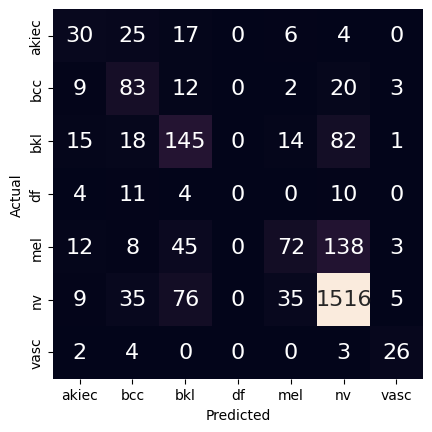

In [46]:
plot_confusion_matrix(y_test, y_pred)

In [59]:
print('\nClassification Report - Test\n')
print(classification_report(y_test, y_pred))


Classification Report - Test

              precision    recall  f1-score   support

           0       0.37      0.37      0.37        82
           1       0.45      0.64      0.53       129
           2       0.48      0.53      0.51       275
           3       0.00      0.00      0.00        29
           4       0.56      0.26      0.35       278
           5       0.86      0.90      0.88      1676
           6       0.68      0.74      0.71        35

    accuracy                           0.75      2504
   macro avg       0.49      0.49      0.48      2504
weighted avg       0.73      0.75      0.73      2504



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
